In [1]:
!pip install git+"https://github.com/soichiro-hattori/tess_cpm"

  Running command git clone -q https://github.com/soichiro-hattori/tess_cpm 'C:\Users\araai\AppData\Local\Temp\pip-req-build-c1s1mgvi'



  Cloning https://github.com/soichiro-hattori/tess_cpm to c:\users\araai\appdata\local\temp\pip-req-build-c1s1mgvi
  Resolved https://github.com/soichiro-hattori/tess_cpm to commit e9617642b2eb3299ebd8e4fdbc09d278573565ee


In [2]:
#pip install scikeras
#pip install tensorflow

This program will contain the ML program that plays around with TESS-CPM data. - testing ground for Dr Ashley's MLP model!


In [2]:
#Load packages :keras, sklearn etc.,
import numpy as np
import pandas as pd
#import torch.utils.data as data
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
def get_training_data(load=False, datafile ='test (1).npz'):
    
    if not load:
        # This grabs the training data files from the appropriate directory
        mypath = './pipelinefiles/'
        training_data_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        training_t = []  
        training_f = []
        training_class = []
        training_info = []
        for f in training_data_files:
            data = np.load(mypath+f)
            all_time=data['all_time']
            all_flux=data['all_flux']
            ra = data['ra']
            dec = data['dec']
            injmu_percentile=data['injmu_percentile']
            injduration=data['injduration']
            injloc_x=-1 * data['injloc_x']
            injloc_y=-1 * data['injloc_y']
            injpeak=data['injpeak']
            
            info = ra,dec,injmu_percentile,injduration,injloc_x,injloc_y,injpeak #injduration, injpeak
            for i, t in enumerate(all_time):
                f = all_flux[i]
                row = np.floor(i/9) - 4
                col = i%9 - 4
                if np.all(np.isnan(f)):
                    continue
                if np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)<=2:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(1)
                    training_info.append(info)
                    
                elif np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)>5:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(0)
                    training_info.append(info)
        np.savez(datafile,training_t = training_t, training_f = training_f,
                training_class = training_class, training_info = training_info)
        return training_t, training_f,training_class,training_info
    else:
        data = np.load(datafile, allow_pickle=True)
        training_t = data['training_t']         # needs to be padded and then shuffled
        training_f = data['training_f']         
        training_class = data['training_class']  
        training_info = data['training_info']   
        return training_t, training_f,training_class,training_info
training_t, training_f,training_class,training_info = get_training_data(load=True)

In [4]:
#padding. for training_t, and f

#max(map(len, arr)) arr being the array name
max(map(len, training_t))
#min(map(len,training_f))

3658

In [5]:
#padding the arrays to match the max size
longest_len = 3658
for i in np.arange(len(training_t)):
    mylen = len(training_t[i])
    if mylen>longest_len:
        longest_len = mylen
new_training_t = np.zeros((len(training_t),longest_len))
new_training_f = np.zeros((len(training_t),longest_len))
for i in np.arange(len(training_t)):
    nl = len(training_t[i])
    before_N=int(longest_len/2-(nl/2))
    new_training_t[i,before_N:nl+before_N] = training_t[i]
    new_training_f[i,before_N:nl+before_N] = training_f[i]

In [6]:
pd.Series(training_f).apply(lambda x: len(x)).idxmax()

973

In [7]:
#new set with 50/50 SNe
count_arr = np.bincount(training_class)
count1 = count_arr[1]
count0 = count_arr[0]
#print(count1)
# we want 2383~ not SNe in the list
df = pd.DataFrame(list(zip(new_training_f, training_class)),
               columns =['new_training_f', 'training_class'])

#order df by class
ndf = df.sort_values(by='training_class', ascending=False)


#select first 2383 Not sne 
ndf_head=ndf.head(2390)

#select last 2383 Sne 
ndf_tail = ndf.tail(2390)

#new dataset with balanced Sne distribution
newDF =pd.concat([ndf_head, ndf_tail], axis=0)
newDF.training_class.value_counts()  # to check distribution 

0    2397
1    2383
Name: training_class, dtype: int64

In [8]:
# shuffle the data frame 
newDF = newDF.sample(frac=1).reset_index(drop=True)
training_f_array = newDF.new_training_f.values
class_t = newDF.training_class.values


In [9]:
type(training_f_array)

numpy.ndarray

In [17]:
# a balanced training set 

X =new_training_f[0:3000]
encoded_Y = training_class[0:3000]

#test set 
X_test = new_training_f[3001:4000]
Y_test = training_class[3001:4000]

In [18]:
X.shape

(3000, 3658)

In [19]:
opt = keras.optimizers.Adam(learning_rate = 0.00001)

In [20]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(3658, input_shape=(3658,), activation='relu'))
    model.add(Dense(500,  activation='relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [21]:
# evaluate model with standardized dataset
estimator = KerasClassifier(model=create_baseline, epochs=20, batch_size=300, verbose=0)
kfold = StratifiedKFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 89.77% (3.50%)


In [22]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience = 30)
# change patience 
# play with learning rate 

In [23]:
model = create_baseline() # saves the create_baseline() function in model 

history = model.fit(
x = X,
y = encoded_Y,
batch_size = 100,
epochs = 100,
validation_split = 0.1,
callbacks = [es])


Epoch 1/100
27/27 [==============================] - 3s 78ms/step - loss: 0.6415 - accuracy: 0.6870 - val_loss: 0.5449 - val_accuracy: 0.8400
Epoch 2/100
27/27 [==============================] - 2s 72ms/step - loss: 0.5332 - accuracy: 0.8481 - val_loss: 0.5386 - val_accuracy: 0.8267
Epoch 3/100
27/27 [==============================] - 2s 72ms/step - loss: 0.5119 - accuracy: 0.9063 - val_loss: 0.5406 - val_accuracy: 0.8967
Epoch 4/100
27/27 [==============================] - 2s 76ms/step - loss: 0.4968 - accuracy: 0.9433 - val_loss: 0.5412 - val_accuracy: 0.9433
Epoch 5/100
27/27 [==============================] - 2s 74ms/step - loss: 0.4839 - accuracy: 0.9596 - val_loss: 0.5510 - val_accuracy: 0.9500
Epoch 6/100
27/27 [==============================] - 2s 71ms/step - loss: 0.4717 - accuracy: 0.9696 - val_loss: 0.5520 - val_accuracy: 0.9500
Epoch 7/100
27/27 [==============================] - 2s 73ms/step - loss: 0.4565 - accuracy: 0.9793 - val_loss: 0.5760 - val_accuracy: 0.9067
Epoch 

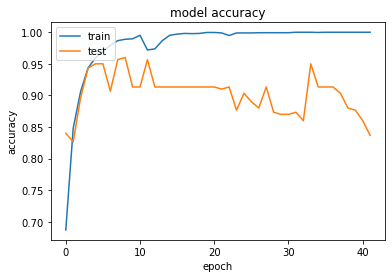

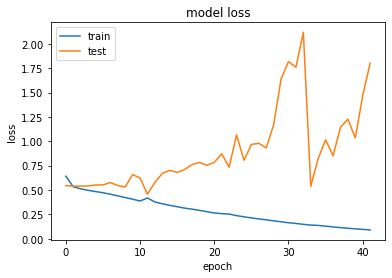

In [24]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# testing testing 

model.evaluate(X_test,Y_test)
 


32/32 [==============================] - 1s 17ms/step - loss: 2.4463 - accuracy: 0.9219


[2.446279764175415, 0.9219219088554382]

In [303]:
# balancing the data

(array([446.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 149.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

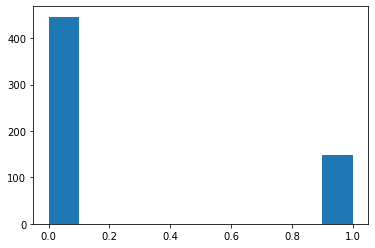

In [342]:
plt.hist(training_class[10:605])

In [26]:
t_train = new_training_t[0:3000]


In [27]:
all_my_guesses = []
for i in np.arange(len(t_train)):
    if np.nanmean(X_test[i])> 1.0:
        my_guess = 1 #I think there is a transient!
    else:
        my_guess = 0 #I think there is NOT a transient
    all_my_guesses.append(my_guess)
#" training class" are the true classes, where 1 means there IS a transient, and 0 means NO transient
cm = confusion_matrix(Y_test, all_my_guesses)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('cm1.png')

IndexError: index 999 is out of bounds for axis 0 with size 999